In [ ]:
# CS663 Project 2 – Group 8
# Mobile Stair and Step Detection
# Author: Yeshvanth Kumar Domala
# Week 2 + Week 3 Combined Notebook


In [ ]:
!pip install opencv-python tensorflow matplotlib --quiet


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive


 CatsDogs_TFDS_Training
'Colab Notebooks'
'Email_confirmation .pdf'
'I94 - Official Website.pdf'
 MARKSHEETS.pdf
 new-student-information-form.pdf
 passport.pdf
'Permission to Enroll for Advanced Computer Architecture(CS625) and Waive Compute.pdf'
'RGB-D stair dataset'
'SYMBI_TRANSCRIPTS_compressed (1).pdf'
 SYMBI_TRANSCRIPTS_compressed.pdf
 Yeshvanth_Resume.pdf


In [9]:
import os

DATASET_PATH = "/content/drive/MyDrive/RGB-D stair dataset/RGB-D stair dataset"

!ls "$DATASET_PATH"




test  train  val


In [10]:
!ls "$DATASET_PATH/train"


depthes  images  labels  segmentations


In [11]:
import pathlib

train_path = pathlib.Path(f"{DATASET_PATH}/train")
val_path   = pathlib.Path(f"{DATASET_PATH}/val")
test_path  = pathlib.Path(f"{DATASET_PATH}/test")

print("Train:", train_path)
print("Validation:", val_path)
print("Test:", test_path)


Train: /content/drive/MyDrive/RGB-D stair dataset/RGB-D stair dataset/train
Validation: /content/drive/MyDrive/RGB-D stair dataset/RGB-D stair dataset/val
Test: /content/drive/MyDrive/RGB-D stair dataset/RGB-D stair dataset/test


In [12]:
import os

for split, path in [("Training", train_path), ("Validation", val_path), ("Testing", test_path)]:
    print(f"\n{split} Set:")
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            print(f"  {cls:15s}: {count:5d} images")



Training Set:
  segmentations  :  2276 images
  labels         :  2276 images
  images         :  2276 images
  depthes        :  2276 images

Validation Set:
  segmentations  :   556 images
  images         :   556 images
  labels         :   556 images
  depthes        :   556 images

Testing Set:
  extrinsicses   :   154 images
  plys           :   154 images
  images         :   154 images
  pcds           :   154 images
  depthes        :   154 images


In [13]:
import os, shutil, random, pathlib
random.seed(42)

# source folders (the real RGB images)
train_images = pathlib.Path(f"{DATASET_PATH}/train/images")
val_images   = pathlib.Path(f"{DATASET_PATH}/val/images")
test_images  = pathlib.Path(f"{DATASET_PATH}/test/images")

# destination structure for quick experiments
BASE = pathlib.Path("/content/stair_dataset_small")
for split in ["train","val","test"]:
    os.makedirs(BASE/split, exist_ok=True)

# copy at most 500 train, 150 val, 150 test samples
def copy_subset(src, dst, n):
    imgs = list(src.glob("*.jpg")) + list(src.glob("*.png"))
    random.shuffle(imgs)
    for p in imgs[:n]:
        shutil.copy2(p, dst/p.name)

copy_subset(train_images, BASE/"train", 500)
copy_subset(val_images,   BASE/"val",   150)
copy_subset(test_images,  BASE/"test",  150)

!find /content/stair_dataset_small -type f | wc -l
!tree -L 2 /content/stair_dataset_small | head -n 40


800
/bin/bash: line 1: tree: command not found


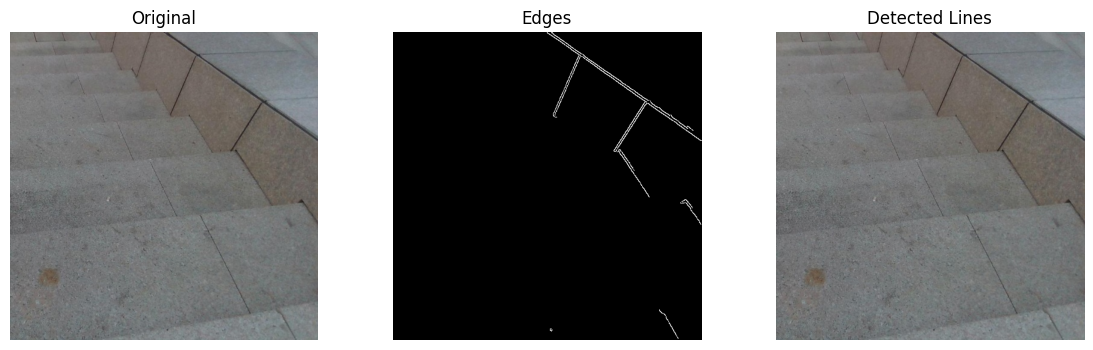

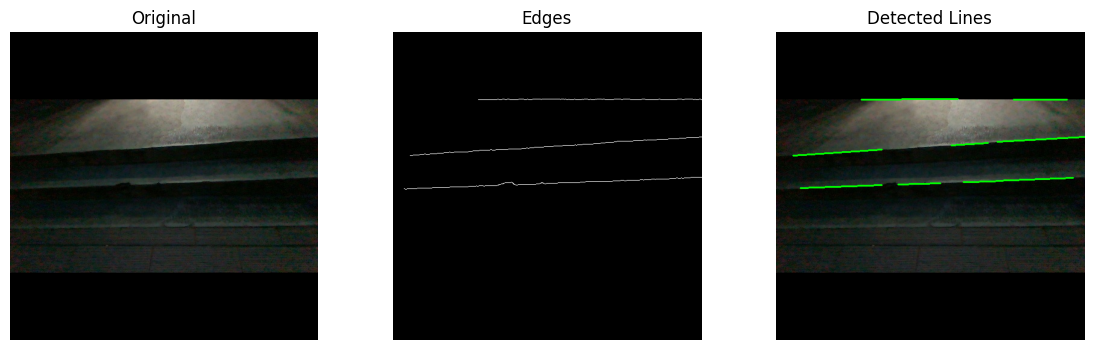

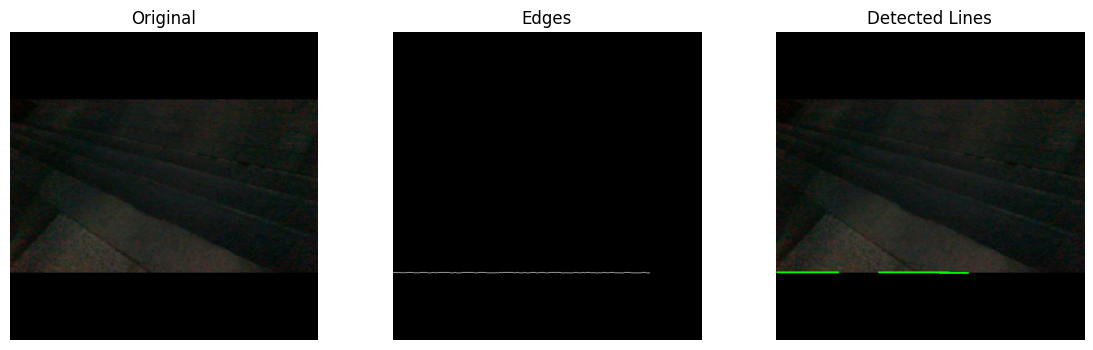

In [14]:
import cv2, numpy as np, matplotlib.pyplot as plt, glob, os

sample_imgs = glob.glob('/content/stair_dataset_small/train/*.jpg')[:3]
os.makedirs('/content/outputs/classical', exist_ok=True)

for img_path in sample_imgs:
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 60, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 60, minLineLength=40, maxLineGap=8)
    vis = img.copy()
    if lines is not None:
        for (x1,y1,x2,y2) in lines[:,0]:
            angle = abs(np.degrees(np.arctan2(y2-y1, x2-x1)))
            if angle < 15:
                cv2.line(vis, (x1,y1), (x2,y2), (0,255,0), 2)

    fig = plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.title('Original'); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.subplot(1,3,2); plt.title('Edges'); plt.imshow(edges,cmap='gray'); plt.axis('off')
    plt.subplot(1,3,3); plt.title('Detected Lines'); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.show()


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
val_gen   = ImageDataGenerator(rescale=1./255)

imgsz=(160,160); bs=16
train_flow = train_gen.flow_from_directory('/content/stair_dataset_small',
                                           classes=['train'], target_size=imgsz,
                                           batch_size=bs, class_mode=None)


Found 500 images belonging to 1 classes.
